In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import box
from scipy.interpolate import griddata
import re
import os

In [82]:
file_name = 'D:/DoctoralSchool/ThematicMaps/monthly/Data/HABP_1MO_202210.csv'
shape_file_path = 'D:/DoctoralSchool/ThematicMaps/Hungary_shapefile/hungary_administrative_boundaries_national_polygon.shp'
variable_label= "RAU_" #RAU_
column_name='rau' #rau
df_month = pd.read_csv(file_name, sep=";",skipinitialspace = True ) # , header=43,on_bad_lines='skip'
df_month.head()
df_month.columns=df_month.columns.str.strip()
print(len(df_month['t']))


#df_month['StationName'].str.strip()
#df_month['StationName'].str.replace('/t| | ','')
#df_month['Latitude']=df_month['Latitude'].str.replace(",",".")
df_month['Latitude'] = df_month['Latitude'].astype('float64')
#df_month['Longitude']=df_month['Longitude'].str.replace(',','.')
df_month['Longitude'] = df_month['Longitude'].astype('float64')
#df_month['Elevation']=df_month['Elevation'].str.replace(',','.')
df_month['Elevation'] = df_month['Elevation'].astype('float64')
#df_month['t']=df_month['t'].str.replace(',','.')

#df_month['rau']=df_month['rau'].str.replace(',','.')
df_month['rau'] = df_month['rau'].astype('float64')
df_month = df_month.drop(df_month[df_month[column_name] == -999].index)

print(len(df_month[column_name]))
print (df_month.columns)
print (df_month)


140
134
Index(['Time', 'StationNumber', 'StationName', 'Latitude', 'Longitude',
       'Elevation', 'rau', 'Q_ra', 't', 'Q_t', 'tn', 'Q_tn', 'tx', 'Q_tx', 'v',
       'Q_v', 'p', 'Q_p', 'u', 'Q_u', 'sg', 'Q_sg', 'sr', 'Q_sr', 'suv',
       'Q_suv', 'fs', 'Q_fs', 'fud', 'Q_fud', 'fx', 'Q_fx', 'fxd', 'Q_fxd',
       'fxdat', 'Q_fxdat', 'p0', 'Q_p0', 'f', 'Q_f', 'upe', 'Q_upe', 'et5',
       'Q_et5', 'et10', 'Q_et10', 'et20', 'Q_et20', 'et50', 'Q_et50', 'et100',
       'Q_et100', 'tsn', 'Q_tsn', 'tviz', 'Q_tviz', 'EOR'],
      dtype='object')
       Time  StationNumber                               StationName  \
0    202210          13704  Sopron Kuruc-domb                          
1    202210          13711  Fertőrákos                                 
2    202210          14707  Sopronhorpács                              
3    202210          15310  Szombathely                                
4    202210          15811  Vasvár                                     
..      ...           

In [83]:
df2 = df_month.loc[:, ['StationNumber','StationName','Latitude','Longitude','Elevation','rau','t','fxdat']]

# Convert DataFrame to GeoDataFrame
df3= df2.loc[:, ['Latitude','Longitude',column_name]]
df3 = gpd.GeoDataFrame(df3)
df3[column_name] = df3[column_name].astype('float64')
#df3=df3.groupby(['StationNumber']).mean()
df3['geometry'] = gpd.points_from_xy(df3["Longitude"], df3["Latitude"])# , crs = epsg_wgs
df3.crs = 'epsg:4326'  # Set CRS to EPSG:4326 (decimal degrees)
df3.head(15)
#print(df3)

# Define coordinate systems
#epsg_wgs = 4326 # World Geodetic System 1984  #23700 
#epsg_utm = 32634 # UTM Zone 14N
#df2=df2.groupby(['StationNumber']).mean()
# Convert latitude and longitude to point data



,Latitude,Longitude,rau,geometry
0,47.6783,16.6022,11.3,POINT (16.60220 47.67830)
1,47.7147,16.6658,12.0,POINT (16.66580 47.71470)
2,47.4806,16.7292,9.0,POINT (16.72920 47.48060)
3,47.1983,16.6478,11.1,POINT (16.64780 47.19830)
4,47.0511,16.8119,12.0,POINT (16.81190 47.05110)
5,46.9103,16.3094,9.4,POINT (16.30940 46.91030)
6,46.9258,16.8128,12.1,POINT (16.81280 46.92580)
7,46.6056,16.6131,8.6,POINT (16.61310 46.60560)
8,46.6511,16.8408,5.3,POINT (16.84080 46.65110)
9,46.4561,16.9706,9.4,POINT (16.97060 46.45610)


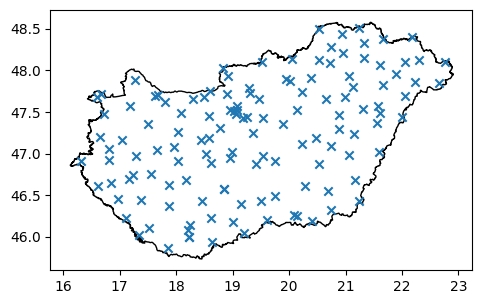

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Plotting of map boundary and sampled points
bnd = gpd.read_file(shape_file_path) #"" C:/Users/erick/Documents/Doctoral School/WREN/Data/ShapeFiles/_1/Hatar_73_tomb.shp
bnd  = bnd.to_crs("epsg:4326")#4326  23700
fig, ax = plt.subplots(1,1, figsize=(8,8))
divider = make_axes_locatable(ax)
bnd.plot( ax=ax, facecolor='w', edgecolor='k', aspect = '1', legend = True)
df3.plot(ax=ax, marker='x')
plt.show()

16.1138866 45.737128000381304 22.897709399999997 48.58525699979512


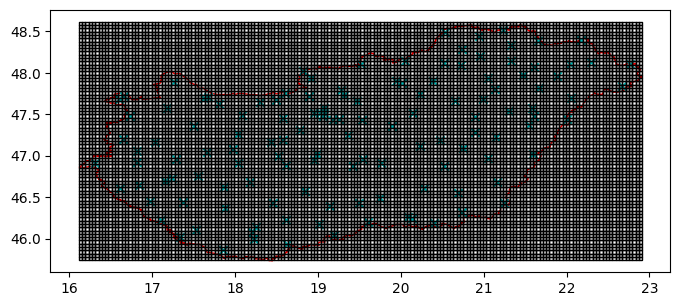

In [6]:
# Create grid to interpolate over
xmin, ymin, xmax, ymax = bnd.total_bounds #Represents field in terms of meters
print (xmin, ymin, xmax, ymax )
# Define cell size
xdelta = 0.04000 # meters
ydelta = 0.04000 # meters

# Create an empty array to save the grid
grid = np.array([])
for x in np.arange(xmin, xmax, xdelta): #min, max step
    for y in np.arange(ymin, ymax, ydelta): #min, max step
        cell = box(x,y, x+xdelta, y+ydelta)
        #print(cell)
        grid = np.append(grid, cell)

epsg_utm = 32634 # UTM Zone 14N
gdf_grid = gpd.GeoDataFrame(grid, columns=['geometry'], crs=epsg_utm)
gdf_grid['centroids'] = gdf_grid['geometry'].centroid
gdf_grid.head()
#print(gdf_grid)

# Plot field boundaries, points, and grid
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.ticklabel_format(useOffset=False)
bnd.plot(ax=ax, facecolor='w', edgecolor='r')
df3.plot(ax=ax, marker='x', facecolor='c')
gdf_grid.plot(ax=ax, facecolor = 'None', edgecolor='k')
plt.show()

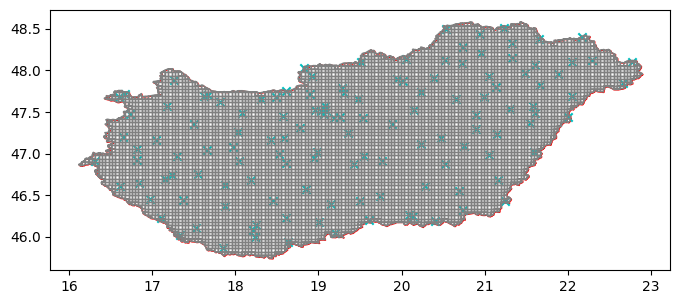

In [7]:
# Clip cells to shapefile boundary
gdf_grid = gpd.clip(gdf_grid, bnd['geometry'].iloc[0])
gdf_grid.reset_index(inplace=True, drop=True)

#Plot
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.ticklabel_format(useOffset=False)
bnd.plot(ax=ax, facecolor='w', edgecolor='r')
df3.plot(ax=ax, marker='x', facecolor='c')
gdf_grid.plot(ax=ax, facecolor = 'None', edgecolor='gray')
plt.show()

In [ ]:
import numpy as np

def idw(x, y, z, xi, yi, power=2):
    """
    Performs inverse distance weighted interpolation in 2D using NumPy.

    Args:
    x: Array of x-coordinates of known data points.
    y: Array of y-coordinates of known data points.
    z: Array of data values at known points.
    xi: Array of x-coordinates of query points.
    yi: Array of y-coordinates of query points.
    power: Power of the distance in the weight calculation (default=2).

    Returns:
    Array of interpolated values at the query points.
      """
    # Calculate distances between known and query points (using broadcasting)
    distances = np.sqrt(((x[:, np.newaxis] - xi)**2) + ((y[:, np.newaxis] - yi)**2))
    print(len(distances))
    # Avoid division by zero for points coinciding with known locations
    distances[distances == 0] = np.finfo(float).eps  

    # Calculate weights with inverse distance power
    weights = 1 / distances**power
    print(len(weights))
    # Interpolate using weighted average (manual loop)
    interpolated_values = np.zeros(len(xi))
    for i in range(len(xi)):
        # Extract weights and data values for current query point
        query_weights = weights[:, i]
        query_z = z

        # Normalize weights (sum to 1)
        query_weights /= np.sum(query_weights)

        # Weighted average
        interpolated_values[i] = np.dot(query_weights, query_z)

    return interpolated_values

In [84]:
import numpy as np


def extract_data_from_dataframe(df, column_name = 't'):
    """
    Extracts coordinates and data from a GeoDataFrame.

    Args:
      df: GeoDataFrame containing 'geometry' column with points and 't' column with data values.

    Returns:
      X: Array of x-coordinates.
      Y: Array of y-coordinates.
      Z: Array of data values.
    """
    # Extract coordinates and data from GeoDataFrame
    X = np.array(df['geometry'].x)
    Y = np.array(df['geometry'].y)
    Z = df[column_name].to_numpy()
    return X, Y, Z


def find_nearest_neighbors_loop(X, Y, xq, yq, n_point):
    """
    Finds nearest neighbors using a loop (alternative approach).

    Args:
      X: Array of x-coordinates of known data points.
      Y: Array of y-coordinates of known data points.
      xq, yq: Coordinates of the query point.
      n_point: Minimum number of neighbors to find.

    Returns:
      indices: List of indices of the nearest neighbors.
    """
    distances = []
    for i in range(len(X)):
        d = np.sqrt(((X[i] - xq) ** 2) + ((Y[i] - yq) ** 2))  # Euclidean distance
        distances.append(d)
    sorted_indices = np.argsort(distances)[:n_point]  # Sort and get indices of n_nearest neighbors
    return sorted_indices.tolist()


def idw_interpolation(xq, yq, X, Y, Z, n_point, p):
    """
    Performs IDW interpolation with a minimum number of points approach.

    Args:
      xq, yq: Coordinates of the query point.
      X: Array of x-coordinates of known data points.
      Y: Array of y-coordinates of known data points.
      Z: Array of data values of known data points.
      n_point: Minimum number of neighbors to use for interpolation.
      p: Power parameter for distance weighting.

    Returns:
      Interpolated value at the query point.
    """
    # Find nearest neighbors
    indices = find_nearest_neighbors_loop(X, Y, xq, yq, n_point)

    # Extract coordinates and data of neighbors
    x_neighbors = X[indices]
    y_neighbors = Y[indices]
    z_neighbors = Z[indices]

    # Calculate weight based on distance and p value
    w_list = []
    for j in range(len(x_neighbors)):
        d = np.sqrt(((xq - x_neighbors[j]) ** 2) + ((yq - y_neighbors[j]) ** 2))
        if d > 0:
            w = 1 / (d**p)
            w_list.append(w)
        else:
            w_list.append(0)  # Set weight to 0 for distance <= 0

  # Check if there is 0 in weight list
    w_check = 0 in w_list
    if w_check == True:
        idx = w_list.index(0)  # Find index for weight=0
        z_idw = z_neighbors[idx]  # Set the value to the current sample value
    else:
        wt = np.transpose(w_list)
        z_idw = np.dot(z_neighbors, wt) / sum(w_list)  # IDW calculation using dot product

    return z_idw

In [85]:
n_point = 5  # Minimum number of neighbors
p = 2 
X,Y,Z = extract_data_from_dataframe(df3, column_name)
xq = gdf_grid['centroids'].x
yq = gdf_grid['centroids'].y
interpolated_values = np.zeros(len(xq))
for i in range(len(xq)):
    interpolated_values[i] = idw_interpolation(xq[i], yq[i], X, Y, Z, n_point, p)
print (interpolated_values)
print( len(interpolated_values),min(interpolated_values), max(interpolated_values))
print(min(Z),max(Z))
gdf_grid[1] = interpolated_values




[19.68838979 20.09445449 18.8729818  ... 12.74714234 12.25402436
 12.62570378]
7217 0.413309238949554 33.04283475125074
0.4 33.1


HABP_1MO_202210


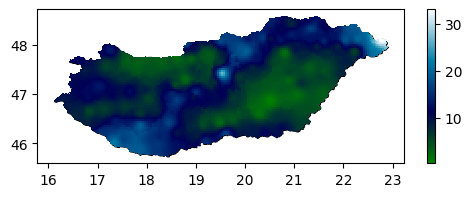

D:\DoctoralSchool\ThematicMaps\monthly\Maps\Rau_interp\RAU_HABP_1MO_202210.csv


In [86]:

maps_path= 'D:\DoctoralSchool\ThematicMaps\monthly\Maps'
variable_folder =""
if "TEMP_" in variable_label:
    variable_folder ='Temp_interp'
elif "RAU_" in variable_label:
    variable_folder ='Rau_interp'
df5=gdf_grid.loc[:, [1]]
df5['longitude']=gdf_grid['centroids'].x
df5['latitude']=gdf_grid['centroids'].y
df5.columns.values[0] = variable_label
df5.head
last_part = os.path.basename(os.path.normpath(file_name))
date_label= last_part[:last_part.rfind(".")]
print(date_label)
ext_file_name = variable_label + date_label
ext_file_name = os.path.join(maps_path,variable_folder, ext_file_name)
csv_file_name = ext_file_name +'.csv'
img_file_name = ext_file_name +'.png' 

# plot the interpolated surface
fig, ax = plt.subplots(1,1, figsize=(6,2))
ax.ticklabel_format(useOffset=False)
bnd.plot(ax=ax, facecolor='w', edgecolor='k')
gdf_grid.plot(ax=ax, column=1, edgecolor='none', antialiased=False, cmap='ocean', legend = True)
plt.savefig(img_file_name)
plt.show()
print(csv_file_name)
df5.to_csv(csv_file_name, sep='\t', index=False)

In [ ]:
##TEST
x = df3['geometry'].x
y = df3['geometry'].y
z = df3['t']
z_np=z.to_numpy()
x_np=x.to_numpy() 
y_np=y.to_numpy() 
print (z_np)
print (type(z_np[0]))
xq = gdf_grid['centroids'].x
yq = gdf_grid['centroids'].y
xq_np=xq.to_numpy()
yq_np=yq.to_numpy()
print (xq_np)
print ("----------------------------------- ")
points=[]
points.clear()
for i in range(len(x_np)):
    points.append([x_np[i],y_np[i]]) 
#print(points, type(points))
#zi = idw_interpolation(points, z_np, xq_np, yq_np)
zi = idw(x_np,y_np,z_np,xq_np,yq_np)
print ('Interpolated resutls:', zi)

In [ ]:
# USE THE PREBIOUSLY CREATED FUINTION FOR IDW INTERPOLATION

import numpy as np

x = df3['geometry'].x
y = df3['geometry'].y
z = df3['t']
z_np=z.to_numpy()
x_np=x.to_numpy() 
y_np=y.to_numpy() 
print (z_np)
print (type(z_np[0]))
xq = gdf_grid['centroids'].x
yq = gdf_grid['centroids'].y
xq_np=xq.to_numpy()
yq_np=yq.to_numpy()
print (xq_np)
print (" ")

# define the output grid points
#xi, yi = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# interpolate the data using IDW
zi = idw(x_np, y_np, z_np, xq_np, yq_np) #,power=2
print ('Interpolated resutls:', zi)
print('max:', max(zi) )
print('min:', min(zi) )
#Save interpolated data values into the geodataframe
gdf_grid[1] = zi

# plot the interpolated surface
# Plot
fig, ax = plt.subplots(1,1, figsize=(9,2))
ax.ticklabel_format(useOffset=False)
bnd.plot(ax=ax, facecolor='w', edgecolor='k')
gdf_grid.plot(ax=ax, column=1, edgecolor='none', antialiased=False, cmap='cividis', legend = True)
#divider = make_axes_locatable(ax)
#p = ax.scatter(*x, c=y, s=50, ec='k', vmin=-3, vmax=15)
#cax = divider.append_axes("right", size="2%", pad=0.38) #add level bar
# add contour lines
#cset = ax.contour(xq, yq, zi, zdir='z', offset=zi.min(), cmap=plt.cm.coolwarm)



#levels = np.arange(1,40,5)
#CS = plt.contour(xq, yq, zi, levels=levels)
#ax.clabel(CS, inline=True, fontsize=10)
plt.show()

#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(xq, yq, zi)
#plt.show()

In [ ]:
p = ax.scatter(*x, c=*y, s=50, ec='k', vmin=-3, vmax=15)
fig.colorbar(p)
plt.show()


In [ ]:
!pip install --upgrade scipy